In [4]:
"""
This creates Figure 1: Receptor quantification and gating of PBMC-derived immune cell types
Same fixed cells as Farhat et al. paper, Figure S3
"""

import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, join
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics.cluster import adjusted_rand_score,rand_score
from sklearn.model_selection import KFold
from pathlib import Path
from sklearn.mixture import GaussianMixture
# from data import FlowDataGMM_Mon_Labeled

# path_here = os.path.dirname(os.path.dirname(__file__))

flowDF = pd.read_feather('FlowDataGMM_Mon_Labeled.ftr')
# flowDF = pd.read_feather('FlowDataGMM_DimWT_Labeled.ftr')

uniquetime = flowDF.Time.unique()
uniquedose = flowDF.Dose.unique()
uniqueday = flowDF.Date.unique()
uniquelig = flowDF.Ligand.unique()

# def makefigure(): 
"""Cells are labeled via Thelper, None, Treg, CD8 or NK """
zflowDF = pd.DataFrame(columns=["Foxp3","CD25","CD4","CD45RA","pSTAT5","CellType"]) # Initializing matrix 
for i in range(len(uniqueday)):
    for j in range(len(uniquedose)):
        for k in range(len(uniquetime)):
            for l in range(len(uniquelig)): 
                # Iterating through each day, time, dose, and ligand of dataset
                flowdataDF = flowDF.loc[(flowDF.Date == uniqueday[i]) & (flowDF.Dose == uniquedose[j])
                & (flowDF.Time == uniquetime[k]) & (flowDF.Ligand == uniquelig[l])]
                if flowdataDF.empty == False:
                    pass
                else: 
                    break # Data was measured for CD3/CD8/CD56 was not measured for the other cell types
                flowdataDF = flowdataDF.dropna(subset = ['Foxp3'])
                flowdataDF = flowdataDF.drop(columns=['CD56','CD3','CD8','Valency','index','Time','Date','Dose','Ligand'])
                flowdataDF = flowdataDF.rename(columns = {'Cell Type':'CellType'})
                sampleDF = flowdataDF.sample(n=100) # Sample size taken of experiment
 
                markerstype = sampleDF.columns[:-2]
                fullcolumn = sampleDF.columns
                for m,mark in enumerate(markerstype):
                    z_marker = stats.zscore(sampleDF[mark].values) # Zscoring dataset
                    sampleDF[mark] = sampleDF[mark].replace([sampleDF[mark].values],[z_marker])
                    
                zflowDF = zflowDF.append(pd.DataFrame({"Foxp3":sampleDF.Foxp3.values,
                                "CD25":sampleDF.CD25.values,"CD4":sampleDF.CD4.values,"CD45RA":sampleDF.CD45RA.values,
                                "pSTAT5":sampleDF.pSTAT5.values,"CellType":sampleDF.CellType.values}))

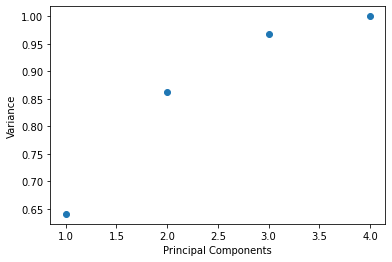

Text(0, 0.5, 'RandScore')

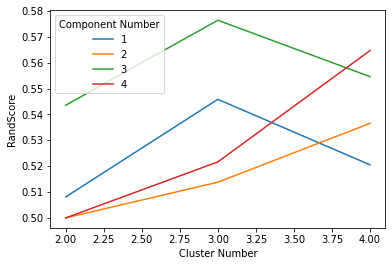

In [5]:
arr = np.arange(1,5,1)
totalvar = np.zeros([len(arr)])
celltypelist = zflowDF.CellType.values
totalDF = zflowDF.drop(columns=['CellType','pSTAT5'])

# Determining variance explained 
for a in range(len(arr)):
    pca = PCA(n_components=arr[a])
    pca.fit_transform(totalDF)
    totalvar[a] = sum(pca.explained_variance_ratio_)

plt.scatter(arr,totalvar)
plt.xlabel("Principal Components")
plt.ylabel("Variance")
plt.show()

celltypelist = zflowDF.CellType.values
totalDF = zflowDF.drop(columns=['CellType','pSTAT5']) # Creating matrix that will be used in GMM model
clusternumb = np.arange(2,5) # Amount of clusters

for ii in range(len(celltypelist)): # Changing cell types to a number
    if celltypelist[ii] == 'None':
        one = 1
        celltypelist[ii] = one
    elif celltypelist[ii] == 'Treg':
        two = 2
        celltypelist[ii] = two
    else: #Thelper
        three = 3 
        celltypelist[ii] = three

pcagmmDF = pd.DataFrame(columns=["Component","Cluster","RandScore"])

for jj in range(len(arr)):
    # Iterating through different number of components to determine which is best
    pca = PCA(n_components=arr[jj])
    pcaDF = pca.fit_transform(totalDF)
    kf = KFold(n_splits=20) # Cross validation for amount of splits
    gmm_labels = np.zeros([len(pcaDF)])
    bestguess = np.zeros([len(clusternumb)])
    for kk in range(len(clusternumb)):
        GMM = GaussianMixture(n_components = clusternumb[kk],covariance_type = 'full',tol = .001,max_iter = 5000,
        reg_covar = 1e-3)
        # Running GMM model on PCA dataset
        for train_index, test_index in kf.split(pcaDF):
            trainX = pcaDF[train_index,:]
            GMM.fit(trainX)
            gmm_labels[test_index] = GMM.predict(pcaDF[test_index,:])
            bestguess = rand_score(celltypelist,gmm_labels) # Comparing the cell type with the GMM predicted 
        # print('Component:',arr[jj],'Cluster',clusternumb[kk],'RandScore',bestguess)
        pcagmmDF = pcagmmDF.append(pd.DataFrame({"Component":[arr[jj]],"Cluster":[clusternumb[kk]],"RandScore": [bestguess]}))


for ll in range(len(arr)):
   randDF = pcagmmDF.loc[pcagmmDF.Component == arr[ll]]
   plt.plot(randDF.Cluster.values,randDF.RandScore.values,label = arr[ll])

plt.legend(title = 'Component Number', loc = 'best')
plt.xlabel('Cluster Number')
plt.ylabel('RandScore')